In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from helper import finalize_plot

sns.set_theme()
sns.set_context("paper", font_scale=1.50)
sns.set_style('ticks', {'font.family': 'Times New Roman'})

In [2]:
visir = pd.read_csv('../Data/VISIR_merged_fluxes_TMP.csv', skipinitialspace=True, 
                    na_values=['#NAME?']).rename({'n_13-30':'n_13_30'}, axis='columns')

In [3]:
x_visir = ['Mstar', 'Lstar', 'Teff', 'logLacc', 'n_13_30', 'incl']
visir_log = ['Mstar', 'Lstar', 'Teff']

In [4]:
# Get Dictionary ready
hist_data = dict(labels=[])
for prop in x_visir:
    hist_data[f'{prop}'] = []
    
for row in visir.itertuples():
    if not np.isnan(row.flux_x):
        hist_data['labels'].append('H$_2$O')
        for prop in x_visir:
            hist_data[f'{prop}'].append(getattr(row, prop))
    
    if not np.isnan(row.flux_y):
        hist_data['labels'].append('Neon[II]')
        for prop in x_visir:
            hist_data[f'{prop}'].append(getattr(row, prop))
    
    if np.isnan(row.flux_x) and np.isnan(row.flux_y):
        hist_data['labels'].append('Missing')
        for prop in x_visir:
            hist_data[f'{prop}'].append(getattr(row, prop))

hist_data = pd.DataFrame(data=hist_data)
hist_data

,labels,Mstar,Lstar,Teff,logLacc,n_13_30,incl
0,H$_2$O,NaN,NaN,NaN,NaN,-1.080330,NaN
1,H$_2$O,4.20,312.00,10250.0,NaN,NaN,63.0
2,H$_2$O,0.87,2.14,4210.0,-0.07,-0.190620,20.0
3,H$_2$O,0.96,0.87,4210.0,-1.12,-0.281149,35.0
4,H$_2$O,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
81,Neon[II],0.72,0.83,NaN,-2.51,-0.057410,43.1
82,Missing,1.22,0.93,4540.0,-0.73,0.807352,34.0
83,Missing,1.50,6.60,7750.0,-0.10,NaN,32.0
84,Missing,1.70,7.60,7500.0,NaN,NaN,23.0


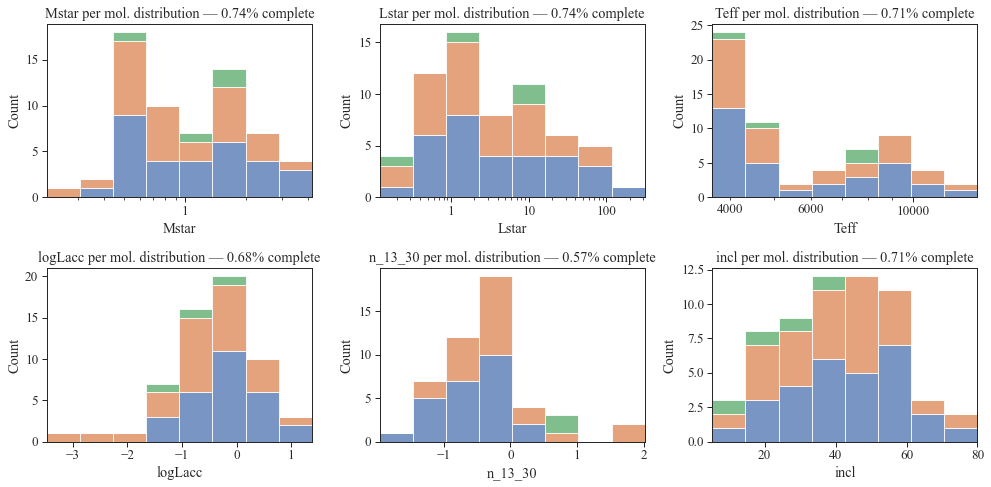

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 7))
data_length = visir.shape[0]

log_scale=False
for prop, ax in zip(x_visir, axes.flat):
    log_scale = prop in visir_log
    completeness = visir[prop].count() / data_length
    sns.histplot(data=hist_data, x=prop, hue='labels', hue_order=['Missing', 'Neon[II]', 'H$_2$O'], 
                 bins='rice', kde=False, stat='count', palette=reversed(sns.color_palette(n_colors=3)),
                 multiple='stack', log_scale=log_scale, legend=False, ax=ax)
    
    title = f'{prop} per mol. distribution — {completeness:.2f}% complete'
    finalize_plot(ax, log=log_scale, xlabel=f'{prop}', title=title)
    # finalize_plot(ax, log=log_scale, xlabel=f'{prop} — {completeness:.2f}%')

plt.tight_layout()

## Notes

Key colors: \
Water: Blue \
Neon: Orange \
Green: Green

- Lacking measurements for very low mass stars
- Lacking Neon measurements for high luminosity stars (same for mass)
- More measurements for colder than the Sun stars
- Lacking measurements (especially water) for low Lacc; data incompleteness?
- Lack of measurements for positive n_13-30; but could be associated to data incompleteness
- Gaussian-like distribution centered at 40-50 deg